In [1]:
import numpy as np

n_stars = 2000

tallness = 0.1 #galaxy sim shennanigans

def generate_points_sphere(n_points, radius=1.0):
    points = []
    while len(points) < n_points:
        x, y, z = np.random.uniform(-radius, radius, 3)
        if x**2 + y**2 + z**2 <= radius**2:
            points.append([x, y, z*tallness])
    return np.array(points)

pos_data = generate_points_sphere(n_stars, 1.0)
pos_data.T.tofile('positions.dat')

In [2]:
def generate_velocity(pos_data, omega_z=1):
    x, y, z = pos_data[:, 0], pos_data[:, 1], pos_data[:, 2]
    
    vx = -omega_z * y
    vy = omega_z * x
    vz = np.zeros_like(z)  
    
    velocities = np.column_stack((vx, vy, vz))
    
    return velocities

vel_data = generate_velocity(pos_data)
vel_data.T.tofile('velocities.dat')

In [18]:
print(vel_data[1999])

[-0.35738061 -0.1388565   0.        ]


In [4]:
import plotly.graph_objects as go

# Extract x, y, z coordinates
x, y, z = pos_data[:, 0], pos_data[:, 1], pos_data[:, 2]

# Plotting in 3D using Plotly
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='blue', opacity=0.6))])
fig.update_layout(scene=dict(aspectmode="data"), title="3D Distribution of Points Inside a Sphere")
fig.show()

In [5]:
import plotly.graph_objects as go

# Extract position and velocity data
x, y, z = pos_data[:, 0], pos_data[:, 1], pos_data[:, 2]
vx, vy, vz = vel_data[:, 0], vel_data[:, 1], vel_data[:, 2]

# Normalize vx and vy for RGB color mapping
vx_normalized = (vx - vx.min()) / (vx.max() - vx.min())
vy_normalized = (vy - vy.min()) / (vy.max() - vy.min())
vz_normalized = np.zeros_like(vz)  # Set vz_normalized directly to 0

# Generate colors based on normalized velocities
colors = [f'rgb({int(255*vx)}, {int(255*vy)}, {int(255*vz)})' for vx, vy, vz in zip(vx_normalized, vy_normalized, vz_normalized)]

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=2, color=colors, opacity=0.8)
)])

fig.update_layout(scene=dict(aspectmode="data"), title="3D Distribution of Points with Velocity-Based Colors")
fig.show()

# Integrator test LeapFrog

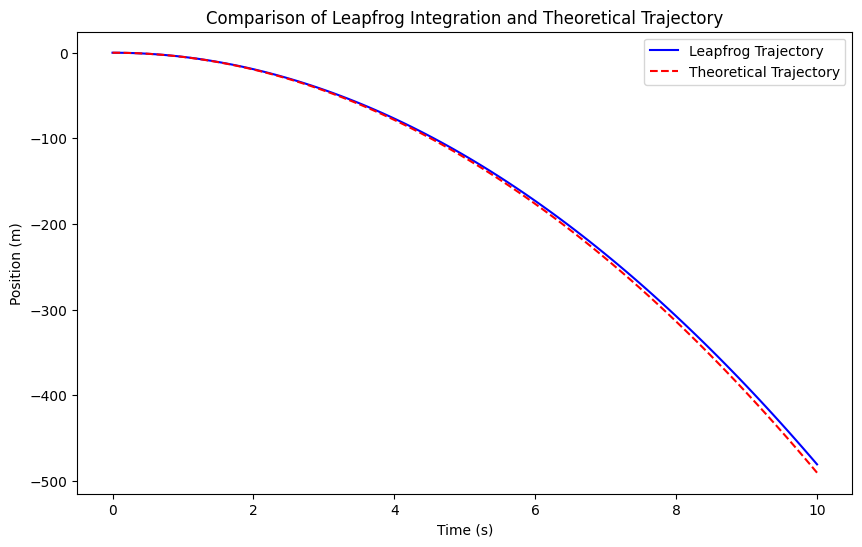

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import fortran_modules

leapfrog = fortran_modules.integrator_module.leapfrog_integrate

# Define constants
g = -9.81  # Gravity in m/s^2 (downward)
dt = 0.1  # Time step in seconds
n_steps = 100  # Number of time steps

# Initial conditions
position = np.array([0.0, 0.0, 0.0], dtype=np.float64)  # Initial position (100m above the ground)
velocity = np.array([0.0, 0.0, 0.0], dtype=np.float64)  # Initial velocity (1 m/s in the x-direction)
acceleration = np.array([0.0, g, 0.0], dtype=np.float64)  # Acceleration (gravity in the y-direction)

# Allocate arrays for results
positions_leapfrog = np.zeros((n_steps, 3), dtype=np.float64)
velocities_leapfrog = np.zeros((n_steps, 3), dtype=np.float64)

# Initial positions and velocities (save the first step)
positions_leapfrog[0] = position
velocities_leapfrog[0] = velocity

# Simulate the trajectory using the leapfrog integrator
for step in range(1, n_steps):
    # Call the Fortran leapfrog integrator
    position, velocity = leapfrog(position, velocity, acceleration, dt)
    
    # Store the results
    positions_leapfrog[step] = position
    velocities_leapfrog[step] = velocity

# Theoretical trajectory: y = y0 + v0 * t + (1/2) * g * t^2
# We assume constant acceleration due to gravity.
time = np.linspace(0, dt * n_steps, n_steps)
theoretical_y = positions_leapfrog[0][0] + 0.5 * g * time**2  # Initial y=100m

# Plot the results
plt.figure(figsize=(10, 6))

# Plot leapfrog trajectory
plt.plot(time, positions_leapfrog[:, 1], label="Leapfrog Trajectory", color='blue')

# Plot theoretical trajectory
plt.plot(time, theoretical_y, label="Theoretical Trajectory", linestyle="--", color='red')

# Labels and title
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Comparison of Leapfrog Integration and Theoretical Trajectory")
plt.legend()

# Show the plot
plt.show()


In [7]:
import numpy as np
import plotly.graph_objects as go
import fortran_modules

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^(-1) s^(-2)
M = 1000000.0          # Mass of the center of mass (for simplicity, 1 kg)
m = 1.0          # Mass of the point particle (1 kg)
dt = 0.1        # Time step in seconds
n_steps = 100000   # Number of steps

# Initial conditions
r = 1.0          # Distance from the center of mass (1 meter)
position = np.array([r, 0.0, 0.0], dtype=np.float64)  # Initial position (on the x-axis)
velocity_magnitude = np.sqrt(G * M / r)  # Circular velocity at distance r
velocity = velocity_magnitude * np.array([0.0, 1, 0.0], dtype=np.float64)  # Initial velocity (perpendicular to position)
acceleration = np.array([0.0, 0.0, 0.0], dtype=np.float64)  # To be calculated based on gravity

# Allocate arrays for results
positions_leapfrog = np.zeros((n_steps, 3), dtype=np.float64)
velocities_leapfrog = np.zeros((n_steps, 3), dtype=np.float64)

# Store initial values
positions_leapfrog[0] = position
velocities_leapfrog[0] = velocity

# Function to compute gravitational acceleration
def gravitational_acceleration(position, M):
    r = np.linalg.norm(position)
    return -G * M * position / r**3

# Simulate the system
for step in range(1, n_steps):
    # Compute acceleration due to gravity
    acceleration = gravitational_acceleration(position, M)
    
    # Call the Fortran leapfrog integrator
    position, velocity = fortran_modules.integrator_module.leapfrog_integrate(position, velocity, acceleration, dt)
    
    # Store the results
    positions_leapfrog[step] = position
    velocities_leapfrog[step] = velocity

# Plot the integrated trajectory using Plotly
fig = go.Figure()

# Plot the trajectory of the particle (Leapfrog)
fig.add_trace(go.Scatter3d(
    x=positions_leapfrog[:, 0], 
    y=positions_leapfrog[:, 1], 
    z=positions_leapfrog[:, 2],
    mode='lines', 
    name='Leapfrog Trajectory',
    line=dict(color='blue', width=4)
))

# Add labels and layout settings
fig.update_layout(
    title="3D Trajectory of the Particle Around the Center of Mass",
    scene=dict(
        xaxis_title="X Position (m)",
        yaxis_title="Y Position (m)",
        zaxis_title="Z Position (m)",
        aspectmode="cube"
    ),
    showlegend=True
)

# Show the plot
fig.show()


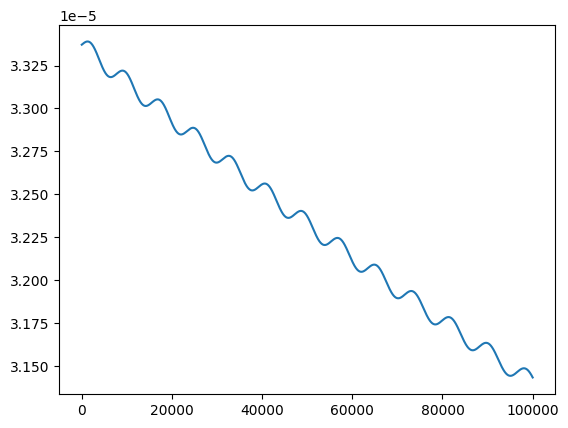

loss percentage : 5.82% for 100000 steps


In [8]:
import numpy as np

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^(-1) s^(-2)
M = 1.0          # Mass of the center of mass (for simplicity, 1 kg)
m = 1.0          # Mass of the point particle (1 kg)

# Function to compute total energy (kinetic + potential)
def compute_total_energy(position, velocity, G=G, M=M, m=m):
    """
    Compute the total energy of the system (kinetic + potential).
    
    Parameters:
    - position (np.array): Position of the particle (3D vector).
    - velocity (np.array): Velocity of the particle (3D vector).
    - G (float): Gravitational constant.
    - M (float): Mass of the center of mass.
    - m (float): Mass of the point particle.
    
    Returns:
    - total_energy (float): The total energy (kinetic + potential).
    """
    
    # Compute the kinetic energy: E_kin = 1/2 * m * v^2
    kinetic_energy = 0.5 * m * np.dot(velocity, velocity)
    
    # Compute the potential energy: E_pot = - G * m * M / r
    r = np.linalg.norm(position)
    potential_energy = -G * m * M / r
    
    # Total energy: E_total = E_kin + E_pot
    total_energy = kinetic_energy + potential_energy
    
    return total_energy

# Compute the total energy
total_energy = [compute_total_energy(positions_leapfrog[i], velocities_leapfrog[i]) for i in range(len(positions_leapfrog))]

plt.plot(total_energy)
plt.show()

print(f'loss percentage : {(1 - total_energy[-1]/total_energy[0])*100:.2f}% for {n_steps} steps')